# Plot glacier terminus positions at different dates
### Jukes Liu

Files used:
    - Terminus box coordinates and Path Row information (Boxes_coords_pathrows.csv)
    - Terminus chains picked by size (terminuspicks_size_2019_07_24.csv)
    - Terminus chains picked by mass (terminuspicks_mass_2019_07_24.csv)
    - DateTimes of satellite images (datetags.csv)

### Import packages and read in csv files

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import types

basepath = '/home/jukes/Documents/Sample_glaciers/'

In [167]:
#Read in file with box coordinates
box_df = pd.read_csv(basepath+'Boxes_coords_pathrows.csv', sep=',', dtype=str)
box_df = box_df.set_index('BoxID')

#Read in files with terminus picks
#size
termini_df_s = pd.read_csv(basepath+'terminuspicks_size_2019_07_25.csv', sep=',', dtype=str, header=1)
termini_df_s.replace(to_replace ="NaN", value = np.nan)
#mass
termini_df_m = pd.read_csv(basepath+'terminuspicks_mass_2019_07_25.csv', sep=',', dtype=str, header=1)
termini_df_m.replace(to_replace ="NaN", value = np.nan)


#Check column names and number of rows for the termini_dfs:
print(termini_df_m.columns.values)
termini_df_rownum = termini_df_m.shape[0]
print(termini_df_rownum)

#look at the DataFrames
#box_df
termini_df_m.head()

['BoxID' 'Img_Date' 'Scale' 'Posfirst' 'Mass' 'Centroid_X' 'Centroid_Y']
584


,BoxID,Img_Date,Scale,Posfirst,Mass,Centroid_X,Centroid_Y
0,001,340052016109,001,55713,3261.8441709793,142.05633544921875,154.42254638671875
1,001,340052015138,000,55713,3924.8247591005,142.82856750488281,155.05717468261719
2,001,340052015106,016,55716,554.6693610866,143.87998962402344,163.02000427246094
3,001,340052014087,000,55719,1801.8953381627,150.345458984375,158.38185119628906
4,001,340052014183,017,53253,427.8556515250,150.59259033203125,165.14814758300781


### Create DateTime objects for plotting timeseries

Option 1 - add in datetimes pulled from metadata files (datetags.csv)

In [168]:
#Read in datetags csv as datetime_df
datetime_df = pd.read_csv(basepath+'datetags.csv', sep=',', dtype=str, header=0, names=['Img_Date', 'datetimes'])

#Turn datetimes into DateTime objects
#grab the datetime strings
datetimes = datetime_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
datetime_df['datetimes'] = datetime_objs
#datetime_df

#Merge the datetags into the termini_df dataframes:
termini_df_m = pd.merge(termini_df_m, datetime_df, on='Img_Date', how='left')
termini_df_s = pd.merge(termini_df_s, datetime_df, on='Img_Date', how='left')

In [130]:
termini_df_m.dtypes

BoxID                 object
Img_Date              object
Scale                 object
Posfirst              object
Mass                  object
Centroid_X            object
Centroid_Y            object
datetimes     datetime64[ns]
dtype: object

Option 2 - turn original date strings 'Img_Date' into DateTime objects

In [169]:
#grab dates from DataFrames:
dates_m = termini_df_m.loc[:, 'Img_Date']
dates_s = termini_df_s.loc[:, 'Img_Date']

#create list to hold new datetime objects
datetime_objs_m = []
datetime_objs_s = []

#convert date string to DateTime
for date in dates_m:
    datetime_obj = datetime.datetime.strptime(date, '%Y%m%d')
    datetime_objs_m.append(datetime_obj)
for date in dates_s:
    datetime_obj = datetime.datetime.strptime(date, '%Y%m%d')
    datetime_objs_s.append(datetime_obj)

#add as new column in dataframes called 'datetimes'
termini_df_m['datetimes'] = datetime_objs_m
termini_df_s['datetimes'] = datetime_objs_s

#Check
termini_df_s.head()

ValueError: unconverted data remains: 16109

### Calculate distances from centroids to the box coordinates and the terminus change rates

In [170]:
#create lists of the subset dataframes (by BoxID) to be concatenated back together at the end
subset_dfs_m = []
subset_dfs_s = []

#LOOP THROUGH AND PERFORM CALCULATIONS ON THE DATA FOR EACH BOXID
for BoxID in box_df.index:
    box_leftmost_x = np.float(box_df.loc[BoxID, 'leftmost_x'])
    box_midpoint_x = np.float(box_df.loc[BoxID, 'midpoint_x'])
#     print("Box"+BoxID, box_leftmost_x, box_midpoint_x)
    
    #subset the full DataFrames to just the Box of interest
    subset_df_m = termini_df_m[termini_df_m['BoxID'] == BoxID].copy()
    subset_df_s = termini_df_s[termini_df_s['BoxID'] == BoxID].copy()
    
    #grab the centroids as an array
    centroids_x_m = np.array(subset_df_m.loc[:, 'Centroid_X'])
    #convert to float
    centroids_x_m = centroids_x_m.astype(float)
    
    centroids_x_s = np.array(subset_df_s.loc[:, 'Centroid_X'])
    #convert to float
    centroids_x_s = centroids_x_s.astype(float)

    
    #CALCULATE THE X DISTANCE between each centroid and the leftmost point/midpoint of box
    xdist_leftmost_m = centroids_x_m - box_leftmost_x
    xdist_midpoint_m = centroids_x_m - box_midpoint_x
    xdist_leftmost_s = centroids_x_s - box_leftmost_x
    xdist_midpoint_s = centroids_x_s - box_midpoint_x

    #add these xdistances to the subset array
    subset_df_m['xdist_leftmost'] = xdist_leftmost_m*15
    subset_df_m['xdist_midpoint'] = xdist_midpoint_m*15
    
    subset_df_s['xdist_leftmost'] = xdist_leftmost_s*15
    subset_df_s['xdist_midpoint'] = xdist_midpoint_s*15
    
    
    #CALCULATE TERMINUS CHANGE RATE
    #sort the subset DataFrame by date of delineation from earliest to latest
    subset_df_m = subset_df_m.sort_values(by='datetimes', ascending=True)
    subset_df_s = subset_df_s.sort_values(by='datetimes', ascending=True)
    
    #create lists to store terminus change rates
    changerates_m = []
    changerates_s = []

    #For each entry in the subset of the overall DataFrame:
    for i in range(0, len(subset_df_m.index)):
        #print(i)
        #for the earliest entry, change rate is NaN
        if i == 0:
            #grab the date of the terminus position
            t_term_m = list(subset_df_m['datetimes'])[i]
            changerates_m.append(np.NaN)
            t_term_s = list(subset_df_s['datetimes'])[i]
            changerates_s.append(np.NaN)
            
        #for all other subsequententries
        if i > 0:
            #grab the date of the terminus position and the previous date
            t_term_m = list(subset_df_m['datetimes'])[i]
            t_term_prev_m = list(subset_df_m['datetimes'])[i-1]
            t_term_s = list(subset_df_s['datetimes'])[i]
            t_term_prev_s = list(subset_df_s['datetimes'])[i-1]

            #grab the terminus position and the previous terminus position
            x_term_m = list(subset_df_m['xdist_midpoint'])[i]
            x_term_prev_m = list(subset_df_m['xdist_midpoint'])[i-1]
            
            x_term_s = list(subset_df_s['xdist_midpoint'])[i]
            x_term_prev_s = list(subset_df_s['xdist_midpoint'])[i-1]
            
            #calculate the change in terminus position and the change in time
            deltax_m = x_term_m - x_term_prev_m
            deltat_m = t_term_m - t_term_prev_m
            
            deltax_s = x_term_s - x_term_prev_s
            deltat_s = t_term_s - t_term_prev_s
            
            #convert deltat object into raw days:
            deltat_m = deltat_m.days
            deltat_s = deltat_s.days
#             print(BoxID, t_term, deltax, deltat)

            #calculate change rate in meters/day if deltat is not zero
            if deltat_m > 0:
                term_changerate_m = deltax_m/deltat_m
            else:
                #if the change in time is zero, enter 'repeat' as terminus change
                #two images from the same date were analyzed
                term_changerate_m = "repeat date"
                
            if deltat_s > 0:
                term_changerate_s = deltax_s/deltat_s
            else:
                term_changerate_s = "repeat date"

            #add the change rate to the change rate list
            changerates_m.append(term_changerate_m)
            changerates_s.append(term_changerate_s)
              
    #print the terminus change rates (m/d)
#     for changerate in changerates_m:
#         print("{0:.2f}".format(changerate_m), "m/d")
    
    #add the terminus change rates to the subset df!
    subset_df_m['changerates(m/d)'] = changerates_m
    subset_df_s['changerates(m/d)'] = changerates_s
    
    #append the subset dfs to the subset dfs listS
    subset_dfs_m.append(subset_df_m)
    subset_dfs_s.append(subset_df_s)

#RECOMBINE THE SUBSET DFs
xdist_df_m = pd.concat(subset_dfs_m)
xdist_df_s = pd.concat(subset_dfs_s)
xdist_df_m

,BoxID,Img_Date,Scale,Posfirst,Mass,Centroid_X,Centroid_Y,datetimes,xdist_leftmost,xdist_midpoint,changerates(m/d)
24,001,340052013148,007,55410,2980.0983600129,144.18644714355469,157.37287902832031,2013-05-28,452.796707,407.796707,NaN
14,001,340052013244,049,52000,2334.2296040626,153.20729064941406,160.57316589355469,2013-09-01,588.109360,543.109360,1.40951
5,001,340052013260,008,56300,1975.6363280925,132.58621215820312,163.45976257324219,2013-09-17,278.793182,233.793182,-19.3323
3,001,340052014087,000,55719,1801.8953381627,150.345458984375,158.38185119628906,2014-03-28,545.181885,500.181885,1.38744
20,001,340052014103,003,55717,2149.4170987740,146.66667175292969,159.50981140136719,2014-04-13,490.000076,445.000076,-3.44886
9,001,340052014135,029,55719,245.0868946670,151.8125,175.625,2014-05-15,567.187500,522.187500,2.41211
37,001,340052014151,046,56611,852.5641373031,119.59999847412109,168.14285278320312,2014-05-31,83.999977,38.999977,-30.1992
25,001,340052014167,042,53871,1477.0533793830,148.38461303710938,165.40382385253906,2014-06-16,515.769196,470.769196,26.9856
4,001,340052014183,017,53253,427.8556515250,150.59259033203125,165.14814758300781,2014-07-02,548.888855,503.888855,2.06998
7,001,340052014215,NaN,NaN,NaN,NaN,NaN,2014-08-03,NaN,NaN,NaN


### Plot terminus position and terminus change vs. datetime for each BoxID

In [171]:
#set dictionaries to call info in DataFrames for each individual BoxID
termini_bybox_m = {}
termini_bybox_s = {}

#grab dataframe for each individual BoxID
for BoxID in box_df.index:
    #grab termini pick info for that BoxID
    termini_bybox_df_m = xdist_df_m[xdist_df_m['BoxID'] == BoxID].copy()
    termini_bybox_df_s = xdist_df_s[xdist_df_s['BoxID'] == BoxID].copy()
    #update to dictionaries
    termini_bybox_m.update( {BoxID: termini_bybox_df_m} )
    termini_bybox_s.update( {BoxID: termini_bybox_df_s} )

Plot for each BoxID

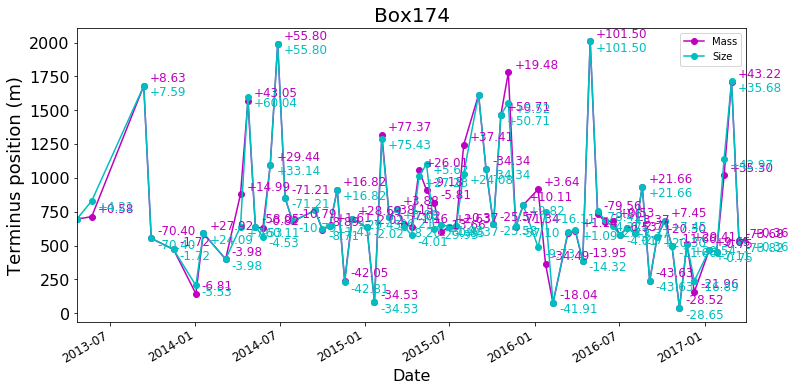

In [176]:
#SET BOX OF INTEREST (BOI) to plot
BOI = '174'

#grab df for BOI and convert datetimes to datetime objs
df_BOI_m = termini_bybox_m[BOI]
df_BOI_s = termini_bybox_s[BOI]

#drop any values that are NaNs or NaTs since they plot improperly
for index, row in df_BOI_m.iterrows():
#     print(index, row['xdist_midpoint'], row['changerates(m/d)'])
    if (np.isnan(row['xdist_midpoint'])) or (row['changerates(m/d)'] == "repeat date"):
        df_BOI_m = df_BOI_m.drop(index, axis=0)
#         print("^ Row dropped")

for index, row in df_BOI_s.iterrows():
#     print(index, row['xdist_midpoint'], row['changerates(m/d)'])
    if (np.isnan(row['xdist_midpoint'])) or (row['changerates(m/d)'] == "repeat date"):
        df_BOI_s = df_BOI_s.drop(index, axis=0)
#         print("^ Row dropped")

#set index to changerate for ease of plotting
df_BOI_m = df_BOI_m.set_index('changerates(m/d)')
df_BOI_s = df_BOI_s.set_index('changerates(m/d)')


#PLOT TERMINUS POSITION 
ax = df_BOI_m.plot(x='datetimes', y='xdist_midpoint', style='mo-', figsize=(12,6))
df_BOI_s.plot(x='datetimes', y='xdist_midpoint', style='co-', ax=ax)
plt.title("Box"+BOI, fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Terminus position (m)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(labels=['Mass' ,'Size'])


#LABEL EACH POINT BY TERMINUS CHANGE RATE
for i, changerate_m in enumerate(df_BOI_m.index):
#     print(type(changerate), changerate)
    #If the rate is a float (number or Nan), format it
    if isinstance(changerate_m, float):
        txt = str("{0:.2f}".format(changerate_m))
        #If it's positive, add a + for clarity:
        if changerate_m > 0:
            txt = "+"+txt
        #don't plot the nans
        if np.isnan(changerate_m):
            txt = " "
    #for others, plot the string
    else:
        txt = str(changerate_m)
    plt.annotate(txt, 
                 xy=(list(df_BOI_m['datetimes'])[i] ,list(df_BOI_m['xdist_midpoint'])[i]), 
                 fontsize=12,
                 xytext=(6 ,4), 
                 textcoords='offset points',
                 color='m')
for i, changerate_s in enumerate(df_BOI_s.index):
#     print(type(changerate), changerate)
    #If the rate is a float (number or Nan), format it
    if isinstance(changerate_s, float):
        txt = str("{0:.2f}".format(changerate_s))
        #If it's positive, add a + for clarity:
        if changerate_s > 0:
            txt = "+"+txt
        #don't plot the nans
        if np.isnan(changerate_s):
            txt = " "
    #for others, plot the string
    else:
        txt = str(changerate_s)
    plt.annotate(txt, 
                 xy=(list(df_BOI_s['datetimes'])[i] ,list(df_BOI_s['xdist_midpoint'])[i]), 
                 fontsize=12,
                 xytext=(6 ,-10), 
                 textcoords='offset points',
                 color='c')

#SAVE FIGURE
plt.savefig(basepath+"Termposition_LS8_ms_Box"+BOI+".png", dpi=200)

_Remnant code on plotting teminus changes:_

In [435]:
# #PLOT:
# plt.figure(figsize=(12, 8))
# plt.plot(changerates.keys(), changerates.values(),'rx', markersize=15)

# #Label the points by the change rate (m/d)
# for i, changerate in enumerate(changerates.values()):
#     txt = "{0:.2f}".format(changerate)
#     plt.annotate(txt, xy=(list(changerates.keys())[i], list(changerates.values())[i]), fontsize=16)

# plt.title("Box"+BOI, fontsize=20)
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Terminus change (m/d)', fontsize=18)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=16)
# plt.gca().invert_yaxis()

# plt.show()